In [873]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torchvision import transforms
import matplotlib.pyplot as plt


class Self_Attn(nn.Module):
    """ Self attention Layer"""

    def __init__(self, in_dim, activation):
        super(Self_Attn, self).__init__()
        self.chanel_in = in_dim
        self.activation = activation

        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(
            m_batchsize, -1, width*height).permute(0, 2, 1)  # B X CX(N)
        proj_key = self.key_conv(x).view(
            m_batchsize, -1, width*height)  # B X C x (*W*H)
        energy = torch.bmm(proj_query, proj_key)  # transpose check
        attention = self.softmax(energy)  # BX (N) X (N)
        proj_value = self.value_conv(x).view(
            m_batchsize, -1, width*height)  # B X C X N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma*out + x
        return out, attention



class Resnet50FPN(nn.Module):
    def __init__(self):
        super(Resnet50FPN, self).__init__()
        # self.resnet = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
        # children = list(list(model.children())[0].children())
        self.resnet = torchvision.models.resnet50(pretrained=True)
        children = list(self.resnet.children())
        self.conv1 = nn.Sequential(*children[:4])
        self.conv2 = children[4]
        self.conv3 = children[5]
        self.conv4 = children[6]
        self.conv5 = children[7]
        self.sa_q1 = Self_Attn(512, nn.ReLU())
        self.sa_q2 = Self_Attn(1024, nn.ReLU())
        self.sa_q3 = Self_Attn(2048, nn.ReLU())
    def forward(self, im_data):
        feat = OrderedDict()
        feat_map = self.conv1(im_data)
        feat_map2 = self.conv2(feat_map)
        feat_map3 = self.conv3(feat_map2)
        feat_map4 = self.conv4(feat_map3)
        feat_map5 = self.conv5(feat_map4)
        feat_map3,_ = self.sa_q1(feat_map3)
        feat_map4,_ = self.sa_q2(feat_map4)
        feat_map5,_ = self.sa_q3(feat_map5)


        feat['map2'] = feat_map2
        feat['map3'] = feat_map3
        feat['map4'] = feat_map4
        feat['map5'] = feat_map5
        return feat

class CountRegressor(nn.Module):
    def __init__(self, input_channels,pool='mean'):
        super(CountRegressor, self).__init__()
        self.pool = pool
        self.regressor = nn.Sequential(
            nn.Conv2d(input_channels, 196, 7, padding=3),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(196, 128, 5, padding=2),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(64, 32, 1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1),
            nn.ReLU(),
        )

    def forward(self, im):
        num_sample =  im.shape[0]
        if num_sample == 1:
            output = self.regressor(im.squeeze(0))
            if self.pool == 'mean':
                output = torch.mean(output, dim=(0),keepdim=True)  
                return output
            elif self.pool == 'max':
                output, _ = torch.max(output, 0,keepdim=True)
                return output
        else:
            for i in range(0,num_sample):
                output = self.regressor(im[i])
                if self.pool == 'mean':
                    output = torch.mean(output, dim=(0),keepdim=True)
                elif self.pool == 'max':
                    output, _ = torch.max(output, 0,keepdim=True)
                if i == 0:
                    Output = output
                else:
                    Output = torch.cat((Output,output),dim=0)
            return Output

In [874]:
resnet = Resnet50FPN()

In [875]:


def extract_features(feature_model, image, boxes,feat_map_keys=['map3','map4'], exemplar_scales=[0.9, 1.1]):
    import math
    N, M = image.shape[0], boxes.shape[2]
    """
    Getting features for the image N * C * H * W
    """
    Image_features = feature_model(image)
    """
    Getting features for the examples (N*M) * C * h * w
    """
    for ix in range(0,N):
        # boxes = boxes.squeeze(0)
        boxes = boxes[ix][0]
        cnter = 0
        Cnter1 = 0
        for keys in feat_map_keys:
            image_features = Image_features[keys][ix].unsqueeze(0)
            if keys == 'map1' or keys == 'map2':
                Scaling = 4.0
            elif keys == 'map3':
                Scaling = 8.0
            elif keys == 'map4':
                Scaling =  16.0
            elif keys == 'map5':
                Scaling =  32.0
            else:
                Scaling = 32.0
            boxes_scaled = boxes / Scaling
            boxes_scaled[:, 1:3] = torch.ceil(boxes_scaled[:, 1:3]) ################### 수정
            boxes_scaled[:, 3:5] = torch.floor(boxes_scaled[:, 3:5])
            boxes_scaled[:, 3:5] = boxes_scaled[:, 3:5] + 1 # make the end indices exclusive 
            feat_h, feat_w = image_features.shape[-2], image_features.shape[-1]
            # make sure exemplars don't go out of bound
            boxes_scaled[:, 1:3] = torch.clamp_min(boxes_scaled[:, 1:3], 0)
            boxes_scaled[:, 3] = torch.clamp_max(boxes_scaled[:, 3], feat_h)
            boxes_scaled[:, 4] = torch.clamp_max(boxes_scaled[:, 4], feat_w)            
            box_hs = boxes_scaled[:, 3] - boxes_scaled[:, 1]
            box_ws = boxes_scaled[:, 4] - boxes_scaled[:, 2]            
            max_h = math.ceil(max(box_hs))
            max_w = math.ceil(max(box_ws))            
            for j in range(0,M):
                y1, x1 = int(boxes_scaled[j,1]), int(boxes_scaled[j,2])  
                y2, x2 = int(boxes_scaled[j,3]), int(boxes_scaled[j,4]) 
                #print(y1,y2,x1,x2,max_h,max_w)
                if j == 0:
                    examples_features = image_features[:,:,y1:y2, x1:x2]
                    if examples_features.shape[2] != max_h or examples_features.shape[3] != max_w:
                        #examples_features = pad_to_size(examples_features, max_h, max_w)
                        examples_features = F.interpolate(examples_features, size=(max_h,max_w),mode='bilinear')                    
                else:
                    feat = image_features[:,:,y1:y2, x1:x2]
                    if feat.shape[2] != max_h or feat.shape[3] != max_w:
                        feat = F.interpolate(feat, size=(max_h,max_w),mode='bilinear')
                        #feat = pad_to_size(feat, max_h, max_w)
                    examples_features = torch.cat((examples_features,feat),dim=0)
            """
            Convolving example features over image features
            """
            h, w = examples_features.shape[2], examples_features.shape[3]
            features =    F.conv2d(
                    F.pad(image_features, ((int(w/2)), int((w-1)/2), int(h/2), int((h-1)/2))),
                    examples_features
                )
            combined = features.permute([1,0,2,3])
            # computing features for scales 0.9 and 1.1 
            for scale in exemplar_scales:
                    h1 = math.ceil(h * scale)
                    w1 = math.ceil(w * scale)
                    if h1 < 1: # use original size if scaled size is too small
                        h1 = h
                    if w1 < 1:
                        w1 = w
                    examples_features_scaled = F.interpolate(examples_features, size=(h1,w1),mode='bilinear')  
                    features_scaled =    F.conv2d(F.pad(image_features, ((int(w1/2)), int((w1-1)/2), int(h1/2), int((h1-1)/2))),
                    examples_features_scaled)
                    features_scaled = features_scaled.permute([1,0,2,3])
                    combined = torch.cat((combined,features_scaled),dim=1)
            if cnter == 0:
                Combined = 1.0 * combined
            else:
                if Combined.shape[2] != combined.shape[2] or Combined.shape[3] != combined.shape[3]:
                    combined = F.interpolate(combined, size=(Combined.shape[2],Combined.shape[3]),mode='bilinear')
                Combined = torch.cat((Combined,combined),dim=1)
            cnter += 1
        if ix == 0:
            All_feat = 1.0 * Combined.unsqueeze(0)
        else:
            All_feat = torch.cat((All_feat,Combined.unsqueeze(0)),dim=0)
    return All_feat

In [894]:
from PIL import Image 
MIN_HW = 384
MAX_HW = 1584
IM_NORM_MEAN = [0.485, 0.456, 0.406]
IM_NORM_STD = [0.229, 0.224, 0.225]
MAPS = ['map3','map4']
Scales = [0.9, 1.1]
class resizeImage(object):
    """
    If either the width or height of an image exceed a specified value, resize the image so that:
        1. The maximum of the new height and new width does not exceed a specified value
        2. The new height and new width are divisible by 8
        3. The aspect ratio is preserved
    No resizing is done if both height and width are smaller than the specified value
    By: Minh Hoai Nguyen (minhhoai@gmail.com)
    """
    
    def __init__(self, MAX_HW=1504):
        self.max_hw = MAX_HW

    def __call__(self, sample):
        image,lines_boxes = sample['image'], sample['lines_boxes']
        
        W, H = image.size
        if W > self.max_hw or H > self.max_hw:
            scale_factor = float(self.max_hw)/ max(H, W)
            new_H = 8*int(H*scale_factor/8)
            new_W = 8*int(W*scale_factor/8)
            resized_image = transforms.Resize((new_H, new_W))(image)
        else:
            scale_factor = 1
            resized_image = image

        boxes = list()
        for box in lines_boxes:
            box2 = [int(k*scale_factor) for k in box]
            y1, x1, y2, x2 = box2[0], box2[1], box2[2], box2[3]
            boxes.append([0, y1,x1,y2,x2])

        boxes = torch.Tensor(boxes).unsqueeze(0)
        resized_image = Normalize(resized_image)
        sample = {'image':resized_image,'boxes':boxes}
        return sample

Transform = transforms.Compose([resizeImage( MAX_HW)])
Normalize = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean=IM_NORM_MEAN, std=IM_NORM_STD)])

with open('./310_box.txt', "r") as fin:
    lines = fin.readlines()

rects1 = list()
for line in lines:
    data = line.split()
    y1 = int(data[0])
    x1 = int(data[1])
    y2 = int(data[2])
    x2 = int(data[3])
    rects1.append([y1, x1, y2, x2])

print("Bounding boxes: ", end="")
print(rects1)

from PIL import Image, ImageCms
import sys

if len(sys.argv) < 2:
		print("Give the filename as an argument")
filename = sys.argv[1]	
im = Image.open('./310.jpg')
if im.mode != "RGB":
  im = im.convert("RGB")

srgb_profile = ImageCms.createProfile("sRGB")
lab_profile  = ImageCms.createProfile("LAB")

rgb2lab_transform = ImageCms.buildTransformFromOpenProfiles(srgb_profile, lab_profile, "RGB", "LAB")
image = ImageCms.applyTransform(im, rgb2lab_transform)

image.load()


sample = {'image': image, 'lines_boxes': rects1}
sample = Transform(sample)
image, boxes = sample['image'], sample['boxes']


image = image.cuda()
boxes = boxes.cuda()


Bounding boxes: [[94, 217, 143, 255], [244, 339, 333, 406], [233, 182, 291, 252]]


In [895]:
resnet.cuda()
resnet.eval()

with torch.no_grad():
  features = extract_features(resnet, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)

In [896]:
regressor = CountRegressor(6, pool='mean')
regressor.cuda()
regressor.load_state_dict(torch.load('./FamNet_Save1.pth'))

regressor.eval()
with torch.no_grad():
  output = regressor(features)

In [897]:
def format_for_plotting(tensor):
    """Formats the shape of tensor for plotting.
    Tensors typically have a shape of :math:`(N, C, H, W)` or :math:`(C, H, W)`
    which is not suitable for plotting as images. This function formats an
    input tensor :math:`(H, W, C)` for RGB and :math:`(H, W)` for mono-channel
    data.
    Args:
        tensor (torch.Tensor, torch.float32): Image tensor
    Shape:
        Input: :math:`(N, C, H, W)` or :math:`(C, H, W)`
        Output: :math:`(H, W, C)` or :math:`(H, W)`, respectively
    Return:
        torch.Tensor (torch.float32): Formatted image tensor (detached)
    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image
    """

    has_batch_dimension = len(tensor.shape) == 4
    formatted = tensor.clone()

    if has_batch_dimension:
        formatted = tensor.squeeze(0)

    if formatted.shape[0] == 1:
        return formatted.squeeze(0).detach()
    else:
        return formatted.permute(1, 2, 0).detach()

In [898]:
output = format_for_plotting(output.detach().cpu())

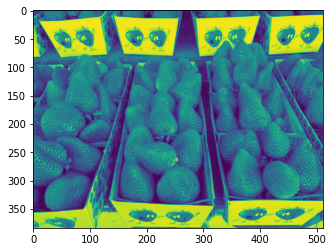

In [899]:
image = image.cpu()
plt.imshow(image[0].detach().numpy())

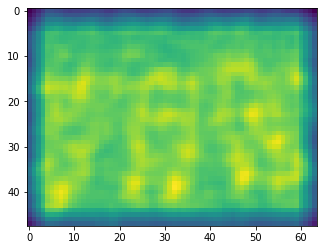

In [900]:
plt.imshow(features[0][0][1].cpu().detach().numpy())

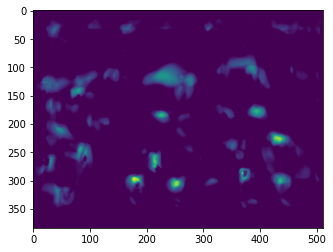

In [901]:
plt.imshow(output)

In [902]:
output.sum().item()

8.325780868530273

In [860]:
output.sum()

tensor(1.2867)